In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from statistics import mean
import math
import statistics
from scipy import stats
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

#Pre-Processing

In [ ]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
!pip install tensorflow-datasets
ds = tfds.load(name="kmnist", split="train")
ds_numpy = tfds.as_numpy(ds)  # Convert `tf.data.Dataset` to Python generator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/kmnist/3.0.1.incompleteJ6IZPV/kmnist-train.tfrecord*...:   0%|          | 0/60…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/kmnist/3.0.1.incompleteJ6IZPV/kmnist-test.tfrecord*...:   0%|          | 0/100…

Dataset kmnist downloaded and prepared to ~/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
X = []
y = []
for ex in ds_numpy:
  y.append(ex['label'])
  X.append(ex['image'])
X = np.array(X)
y = np.array(y)
X = X[:,:,:,0]
X = X.reshape(X.shape[0], 784)
print(X.shape)


<class 'tensorflow_datasets.core.dataset_utils._IterableDataset'>
60000
(60000, 28, 28)
(60000,)
(60000, 784)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


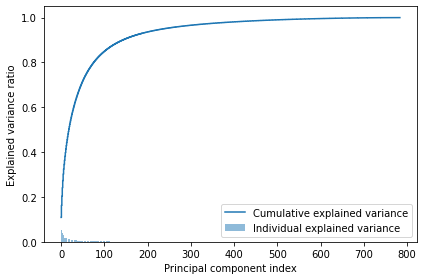

Best Number of Principal Components: 122


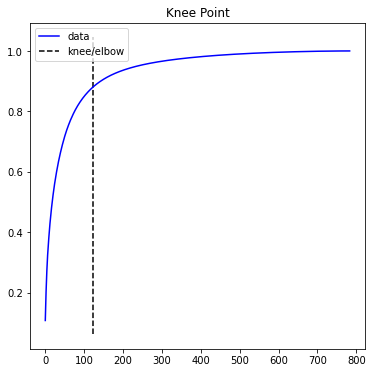

In [ ]:
#determining the best number of princial components to reduce the dimensions to
!pip install kneed
from kneed import KneeLocator
pca = PCA()
# Determine transformed features
X_pca = pca.fit_transform(X)
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
kn = KneeLocator(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, curve = 'concave', direction = 'increasing')
kn.plot_knee()
print("Best Number of Principal Components: {}".format(kn.knee))



In [ ]:
#PCA to reduce the dimensions of KMNIST
pca = PCA(n_components = 122)
X = pca.fit_transform(X)

#Iterative Clustering

In [ ]:
#creating list of IDs for samples in dataset 
def createList(r1, r2):
    return [item for item in range(r1, r2)]
      
# Driver Code
r1, r2 = 0, len(y)
lstOfIds = createList(r1, r2)

In [ ]:
#Calculates homogeneity per cluster
def calculateHomogeneity(predicted, actual, origNumLabels = 10):
  numPredictedClusters = len(np.unique(predicted)) # number of predicted clusters
  numActual = len(np.unique(actual)) # number of actual ground truth classes

  clusterHomogeneities = []
  clusterTotals = []
  for i in range(numPredictedClusters):
    homogeneityList = np.zeros(origNumLabels)
    # find all of the indices of the samples in each cluster 
    ind = np.where(np.isin(predicted,i))[0]
    actual = np.array(actual)
    actualVals = actual[ind] # finding the actual values in that cluster
    totalNumInCluster = len(actualVals) # finding the amount of points in that cluster
    clusterTotals.append(totalNumInCluster)
    for i in actualVals:
      homogeneityList[i] = homogeneityList[i] + 1
    homogeneityList = homogeneityList / totalNumInCluster
    clusterHomogeneities.append(max(homogeneityList))
  return [clusterHomogeneities, clusterTotals] 

In [ ]:
def iterativeClustering(threshold, data, actual, IdList, centers = [], properlyClassified = [], hsOfRemoved = [], lengthOfData = 60000):
 
  print("Number of data points to work with: ", data.shape[0])

  #finding the best k

  k = 1;
  currHomogeneity = 0.0;
  while (currHomogeneity < threshold and k <= math.sqrt(lengthOfData/2)):
    k = k + 1
    model = sk.cluster.KMeans(n_clusters = k)
    clusterLabels = model.fit_predict(data)
    clusterCenters = model.cluster_centers_ # getting the centers of the clusters
    homogeneityList = calculateHomogeneity(clusterLabels, actual) 
    currHomogeneity = np.max(homogeneityList[0])
  

  predLabels = clusterLabels
  homogeneityPCluster = homogeneityList[0]
  
  for i in range(k):
    print("Homogeneity of cluster {} is {}".format(i,homogeneityPCluster[i]))
  
  #find clusters to remove
  clustersToRemove = []
  bestClusterHS = currHomogeneity
  print("this is max: {}".format(bestClusterHS))
  indexOfMax = homogeneityPCluster.index(bestClusterHS) 
  clusterTotals = homogeneityList[1]
  for i in range(k):
    diffBtwnBest = bestClusterHS - homogeneityPCluster[i]
    
    if i == indexOfMax:
      clustersToRemove.append(i)
      
      print("Cluster sectioned off:", i)
      continue
    if diffBtwnBest < .03 and homogeneityPCluster[i] >= threshold and clusterTotals[i]> math.sqrt(len(data)):
      
      clustersToRemove.append(i)
      
      print("Cluster sectioned off:", i)

  pointsRemoved = 0
  totalPoints = sum(clusterTotals)
  for i in range(k):
    if i in clustersToRemove:
      pointsRemoved += clusterTotals[i] 

  
  remainingDatapoints = totalPoints - pointsRemoved #check total points
  print("percent removed: {}".format(pointsRemoved/lengthOfData))
  if remainingDatapoints < math.sqrt(lengthOfData) or (pointsRemoved <= 0.01*lengthOfData):
    print("DONE - we have all clusters")
    print("properly classified type: {}. Remaining type: {}".format(type(properlyClassified), type(data)))
    return list(properlyClassified), list(IdList), list(hsOfRemoved), list(centers)

  else: 
    #remove these dataPoints in cluster chosen to be separated
    #recluster remaining
    IdList = np.array(IdList)

    for num in clustersToRemove:
      indices = np.where(np.isin(predLabels,num))
      toAppend = IdList[indices]
      properlyClassified.append(toAppend)
      centers.append(clusterCenters[num])
      hsOfRemoved.append(homogeneityPCluster[num])
      data = np.delete(data, indices, axis=0)
      actual = np.delete(actual, indices)
      IdList = np.delete(IdList,indices)
      predLabels = np.delete(predLabels,indices)
    
    print("Good clusters removed. Starting over with smaller dataset.")
    print("Length of properly classified: ", len(properlyClassified))
    count = 0
    for i in properlyClassified:
      print("Length of cluster {} : {}".format(count, len(i)))
      count = count + 1
    return iterativeClustering(threshold, data, actual,IdList, centers, properlyClassified, hsOfRemoved)

In [ ]:
separatedClusters, remainingPoints, scores, centers = iterativeClustering(0.8,X,y,lstOfIds)

Number of data points to work with:  60000
Homogeneity of cluster 0 is 0.5001536098310292
Homogeneity of cluster 1 is 0.27664064148554546
Homogeneity of cluster 2 is 0.5149693808119755
Homogeneity of cluster 3 is 0.2862830482115086
Homogeneity of cluster 4 is 0.8445003430139493
Homogeneity of cluster 5 is 0.2805515400867341
Homogeneity of cluster 6 is 0.8047974969581088
this is max: 0.8445003430139493
Cluster sectioned off: 4
percent removed: 0.07288333333333333
Good clusters removed. Starting over with smaller dataset.
Length of properly classified:  1
Length of cluster 0 : 4373
Number of data points to work with:  55627
Homogeneity of cluster 0 is 0.23529121664940572
Homogeneity of cluster 1 is 0.27929992707573703
Homogeneity of cluster 2 is 0.40086088469640074
Homogeneity of cluster 3 is 0.5153614121327226
Homogeneity of cluster 4 is 0.8088760414895426
this is max: 0.8088760414895426
Cluster sectioned off: 4
percent removed: 0.09801666666666667
Good clusters removed. Starting over w

In [ ]:
mean(scores)

0.8589290850475183

#Training/Testing classifier with subtypes from iterative clustering, traditional clusters (same number as the number of subtypes we got from iterative clustering), and ground truth classes

In [ ]:
#finds the ids of the samples in X-text (used to determine number of misclassified points)
def getIds(X_test):
  indexLst = []
  for lst in X_test:
    index = int(lst[-1])
    indexLst.append(index)
  return indexLst

In [ ]:
#find points misclassified in each cluster
def findMisclassified(X, X_test, y, y_test,listOfIndices): 
  numMisclassified = []
  indicesInX = listOfIndices #np.where(np.isin(predLabels,num))
  groundTruths = [y[i] for i in indicesInX]
  for i in np.unique(y_test):
    numMisclassifiedPerCluster = 0
    indicesOfInterest = np.where(y_test == i)[0]
    truthLabels = [groundTruths[i] for i in indicesOfInterest]
    majorityClassLabel = int(stats.mode(truthLabels)[0])
    for i in truthLabels:
      if i!=majorityClassLabel:
        numMisclassifiedPerCluster = numMisclassifiedPerCluster + 1
    numMisclassified.append(numMisclassifiedPerCluster)
  return numMisclassified

In [ ]:
#creating labels for clusters from iterative clustering

labelsForEverything = np.zeros(60000)

labelForRemaining = len(separatedClusters)

for label in range(len(separatedClusters)):
  for index in separatedClusters[label]:
    labelsForEverything[index] = label


for index in remainingPoints: 
  labelsForEverything[index] = labelForRemaining

indices = np.where(labelsForEverything==labelForRemaining)
print(indices)

copyOfX = X
XRemoved = np.delete(copyOfX,indices[0],axis=0)

copyOfEverything = labelsForEverything
labelsForRemoved = np.delete(copyOfEverything,indices[0])

(array([    0,     3,     5, ..., 59989, 59996, 59998]),)


In [ ]:
#Classify MNIST into n classes with iterative clustering subtypes
r1, r2 = 0, len(list(y))
ids = createList(r1, r2)
X1 = pd.DataFrame(X)
X1['ID'] = ids
X1 = X1.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X1, labelsForEverything, test_size = 0.2, stratify = labelsForEverything)
lstOfIndices = getIds(X_test)

X_train1 = []

for i in range(len(X_train)):
  everythingButLast = X_train[i][:-1]
  X_train1.append(everythingButLast)
    
  
X_train1 = np.array(X_train1)

X_test1 = []
for j in range(len(X_test)):
  X_test1.append(X_test[j][:-1])

X_test1 = np.array(X_test1)


svm = SVC()
svm.fit(X_train1, y_train)
svmResults = svm.predict(X_test1)
matrix = confusion_matrix(y_test, svmResults)
accuracies = matrix.diagonal()/matrix.sum(axis = 1)
print("Recall per class for our ITERATIVE subtypes: ", recall_score(y_test, svmResults, average = None))
print("Precision per class for our ITERATIVE subtypes: ", precision_score(y_test, svmResults, average = None))
print("Accuracies per class for our ITERATIVE subtypes: ", accuracies)
print("Number of points misclassified per cluster for our ITERATIVE subtypes: ", findMisclassified(X1, X_test1, y, y_test,lstOfIndices))
print("Overall accuracy for our ITERATIVE subtypes: ", accuracy_score(y_test, svmResults))
print("Recall for our ITERATIVE subtypes: ", recall_score(y_test, svmResults, average = 'macro'))
print("Precision for our ITERATIVE subtypes: ", precision_score(y_test, svmResults, average = 'macro'))
print("Number of points Misclassified per cluster: ", mean(findMisclassified(X1, X_test1, y, y_test,lstOfIndices)))

Recall per class for our ITERATIVE subtypes:  [0.94628571 0.96088435 0.96844181 0.95913462 0.95810811 0.92307692
 0.91363636 0.92641509 0.8705036  0.89473684 0.9017094  0.89928058
 0.87421384 0.88764045 0.79527559 0.904      0.91842105 0.95463456]
Precision per class for our ITERATIVE subtypes:  [0.97297297 0.94166667 0.95247333 0.96610169 0.95810811 0.95846645
 0.92626728 0.95711501 0.94285714 0.96356275 0.95045045 0.93984962
 0.96527778 0.95951417 0.9266055  0.8968254  0.93817204 0.91028037]
Accuracies per class for our ITERATIVE subtypes:  [0.94628571 0.96088435 0.96844181 0.95913462 0.95810811 0.92307692
 0.91363636 0.92641509 0.8705036  0.89473684 0.9017094  0.89928058
 0.87421384 0.88764045 0.79527559 0.904      0.91842105 0.95463456]
Number of points misclassified per cluster for our ITERATIVE subtypes:  [145, 233, 89, 136, 127, 73, 40, 105, 58, 13, 33, 66, 15, 52, 20, 4, 75, 2865]
Overall accuracy for our ITERATIVE subtypes:  0.9395
Recall for our ITERATIVE subtypes:  0.9142443

In [ ]:

print("Accuracy for - unclustered: ", mean([0.94628571, 0.96088435, 0.96844181, 0.95913462, 0.95810811, 0.92307692,
 0.91363636, 0.92641509, 0.8705036,  0.89473684, 0.9017094,  0.89928058,
 0.87421384, 0.88764045, 0.79527559, 0.904, 0.91842105, 0.95463456]))
print("Precision for - unclustered: ", mean([0.97297297, 0.94166667, 0.95247333, 0.96610169, 0.95810811, 0.95846645,
 0.92626728, 0.95711501, 0.94285714, 0.96356275, 0.95045045, 0.93984962,
 0.96527778, 0.95951417, 0.9266055,  0.8968254,  0.93817204, 0.91028037]))
print("Recall for - unclustered: ", mean([0.94628571, 0.96088435, 0.96844181, 0.95913462, 0.95810811, 0.92307692,
 0.91363636, 0.92641509, 0.8705036,  0.89473684, 0.9017094,  0.89928058,
 0.87421384, 0.88764045, 0.79527559, 0.904, 0.91842105]))
print("Misclassified for - unclustered: ", mean([145, 233, 89, 136, 127, 73, 40, 105, 58, 13, 33, 66, 15, 52, 20, 4, 75]))

Accuracy for - unclustered:  0.9142443822222223
Precision for - unclustered:  0.9459203738888888
Recall for - unclustered:  0.9118684894117647
Misclassified for - unclustered:  75.52941176470588


In [ ]:
print(len(separatedClusters))

17


In [ ]:
# Classify MNIST into ground truth classes (no clustering)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
svm = SVC()
svm.fit(X_train, y_train)
svmResults = svm.predict(X_test)
# at this point, we should have an accuracy metric
matrix = confusion_matrix(y_test, svmResults)
accuracies = matrix.diagonal()/matrix.sum(axis=1)
print("Accuracies per class for a simple SVM classifer: ", accuracies)
print("Overall accuracy for a simple SVM classifier: ", accuracy_score(y_test, svmResults))
print("Recall for a simple SVM classifier: ", recall_score(y_test, svmResults, average = 'macro'))
print("Precision for a simple SVM classifier: ", precision_score(y_test, svmResults, average = 'macro'))

Accuracies per class for a simple SVM classifer:  [0.98       0.96833333 0.95166667 0.97333333 0.95666667 0.9575
 0.96083333 0.975      0.97666667 0.97583333]
Overall accuracy for a simple SVM classifier:  0.9675833333333334
Recall for a simple SVM classifier:  0.9675833333333334
Precision for a simple SVM classifier:  0.9677279160231438


In [ ]:
#classifying MNIST into n classes using traditional k-means clusters

model = sk.cluster.KMeans(n_clusters = len(separatedClusters))
clusterLabels = model.fit_predict(X)
centersForTrad = model.cluster_centers_


r1, r2 = 0, len(list(y))
ids = createList(r1, r2)
X1 = pd.DataFrame(X)
X1['ID'] = ids
X1 = X1.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X1, clusterLabels, test_size = 0.2, stratify = clusterLabels)
lstOfIndices = getIds(X_test)

X_train1 = []

for i in range(len(X_train)):
  everythingButLast = X_train[i][:-1]
  X_train1.append(everythingButLast)
    
  
X_train1 = np.array(X_train1)

X_test1 = []
for j in range(len(X_test)):
  X_test1.append(X_test[j][:-1])

X_test1 = np.array(X_test1)

svm = SVC()
svm.fit(X_train1, y_train)
svmResults = svm.predict(X_test1)
matrix = confusion_matrix(y_test, svmResults)
accuracies = matrix.diagonal()/matrix.sum(axis = 1)
print("Accuracies per class for our TRADITIONAL subtypes: ", accuracies)
print("Recall per class for our TRADITIONAL subtypes: ", recall_score(y_test, svmResults, average = None))
print("Precision per class for our TRADITIONAL subtypes: ", precision_score(y_test, svmResults, average = None))
print("Overall accuracy for our TRADITIONAL subtypes: ", accuracy_score(y_test, svmResults))
print("Recall for our TRADITIONAL subtypes: ", recall_score(y_test, svmResults, average = 'macro'))
print("Precision for our TRADITIONAL subtypes: ", precision_score(y_test, svmResults, average = 'macro'))
print("Number of points Misclassified per cluster FOR TRADITIONAL: ", mean(findMisclassified(X1, X_test1, y, y_test,lstOfIndices)))


Accuracies per class for our TRADITIONAL subtypes:  [0.9442446  0.90444444 0.9753886  0.95178571 0.94024605 0.95547945
 0.95505618 0.94963145 0.89007092 0.91046658 0.95228628 0.9773622
 0.98013903 0.93108729 0.96031746 0.96938776 0.95628903]
Recall per class for our TRADITIONAL subtypes:  [0.9442446  0.90444444 0.9753886  0.95178571 0.94024605 0.95547945
 0.95505618 0.94963145 0.89007092 0.91046658 0.95228628 0.9773622
 0.98013903 0.93108729 0.96031746 0.96938776 0.95628903]
Precision per class for our TRADITIONAL subtypes:  [0.95281307 0.93135011 0.96911197 0.90646259 0.94690265 0.94469526
 0.96453901 0.94846626 0.93656716 0.94875164 0.94291339 0.9622093
 0.95639535 0.9544741  0.9633758  0.96656977 0.95543672]
Overall accuracy for our TRADITIONAL subtypes:  0.9520833333333333
Recall for our TRADITIONAL subtypes:  0.9472754730689352
Precision for our TRADITIONAL subtypes:  0.9500608317513655
Number of points Misclassified per cluster FOR TRADITIONAL:  240.64705882352942


#Paper Results
##Class Distributions (Iterative vs Traditional Clustering)
##cluster center pictures

In [ ]:
#Calculating homogeneity of unclustered
labels = y


numLabelsPerClass = {}

for i in remainingPoints:
  label = labels[i]
  #print(label)
  if label in numLabelsPerClass:
    numLabelsPerClass[label] += 1
  else:
    numLabelsPerClass[label] = 1

hsPClass = [] #HS per class in unclustered
for key in numLabelsPerClass:
  homogeneity = (numLabelsPerClass[key]/len(remainingPoints))
  hsPClass.append(homogeneity)

hsWoUnclustered = scores
print(scores)
#print(hsWoUnclustered)
hsWUnclustered = hsWoUnclustered
hsWUnclustered.append(max(hsPClass))
print(hsWUnclustered)


print("this is the max HS for the unclustered data: ",max(hsPClass))
print("this is the avg homogeneity w/ unclustered: {}".format(mean(hsWUnclustered)))
print("this is the avg homogeneity w/o unclustered {}".format(mean(scores)))

[0.8018967334035827, 0.8032786885245902, 0.8059925093632959, 0.8088760414895426, 0.8202035431586883, 0.8408538232910024, 0.8422712933753943, 0.8445003430139493, 0.8461169702780441, 0.8527577937649881, 0.8557345515748979, 0.8600682593856656, 0.8858812673023685, 0.8978562421185372, 0.9197396963123644, 0.955639097744361, 0.960127591706539]
[0.8018967334035827, 0.8032786885245902, 0.8059925093632959, 0.8088760414895426, 0.8202035431586883, 0.8408538232910024, 0.8422712933753943, 0.8445003430139493, 0.8461169702780441, 0.8527577937649881, 0.8557345515748979, 0.8600682593856656, 0.8858812673023685, 0.8978562421185372, 0.9197396963123644, 0.955639097744361, 0.960127591706539, 0.19744580742732315]
this is the max HS for the unclustered data:  0.19744580742732315
this is the avg homogeneity w/ unclustered: 0.8221800140686186
this is the avg homogeneity w/o unclustered 0.8221800140686186
